In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage as sk

from skimage import exposure
from skimage import io
from skimage import feature
from skimage import filters

%matplotlib inline

In [6]:
img_file = '/Users/kpuhger/Desktop/SampleGFP.tif'
img = sk.io.imread(img_file)

In [13]:
img.shape

(15, 572, 702)

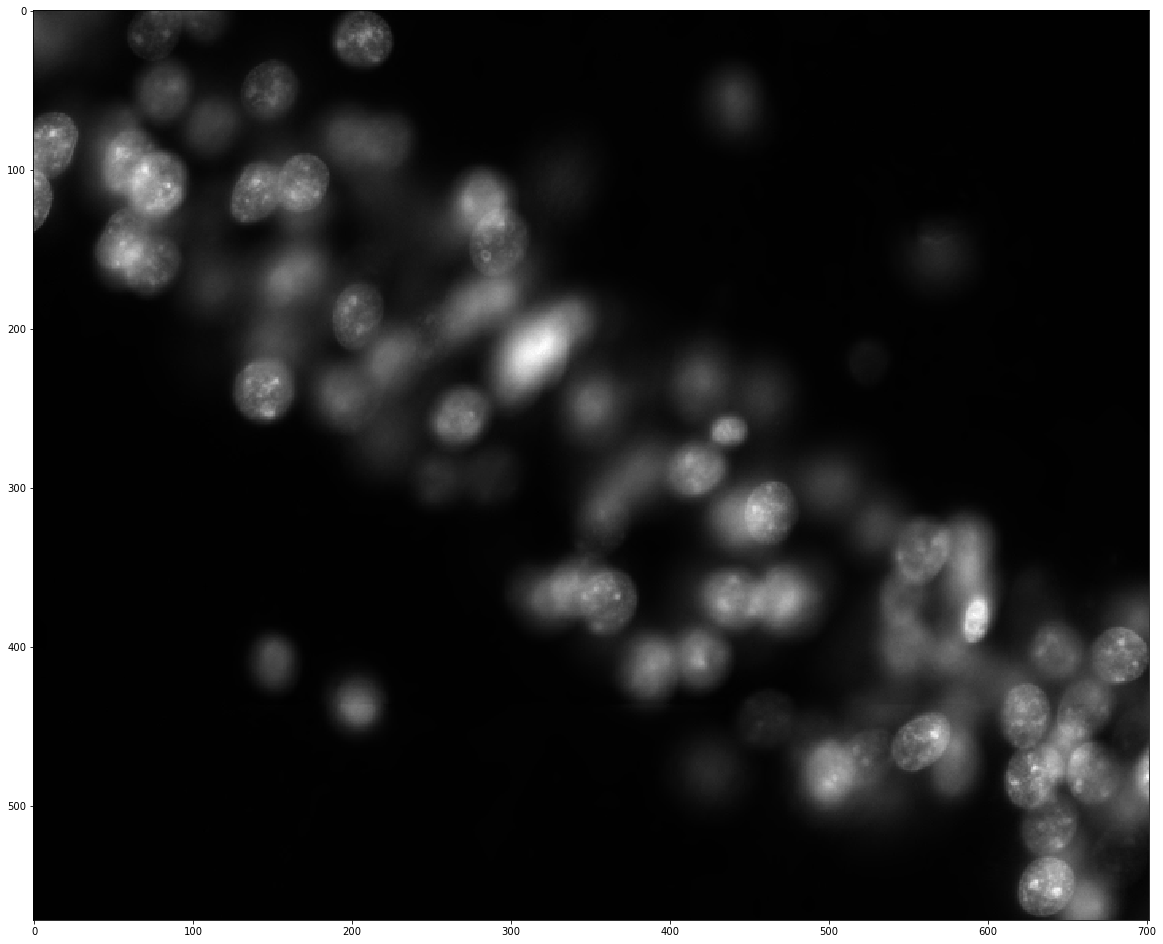

In [15]:
f, ax = plt.subplots(1,1, figsize=(20,20))
ax.imshow(img[9, :, :], cmap='gray');